# Wikipedia movie plots

## About the dataset
The dataset used in this analyzis contains descriptions of over 34 000 movies scraped from Wikipedia. The most important field of this dataset is the column containing short plot description of different movies. 

Dataset could be find here: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

More on the content:
- Release Year - Year in which the movie was released
- Title - Movie title
- Origin/Ethnicity - Origin of movie (i.e. American, Bollywood, Tamil, etc.)
- Director - Director(s)
- Cast - Main actor and actresses
- Genre - Movie Genre(s)
- Wiki Page - URL of the Wikipedia page from which the plot description was scraped
- Plot - Long form description of movie plot (WARNING: May contain spoilers!!!)


## Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/kamil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading the dataframe

In [36]:
df = pd.read_csv('./wiki_movie_plots.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In this analysis i am going to focus only on the `Plot` column so ones like `Director` or `Cast` are going to be dropped. 

# Dataframe cleaning

In [38]:
df.drop(['Director', 'Genre', 'Cast', "Origin/Ethnicity"], axis=1, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Release Year  34886 non-null  int64 
 1   Title         34886 non-null  object
 2   Wiki Page     34886 non-null  object
 3   Plot          34886 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None


,Release Year,Title,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King","https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


Now we need to get rid of the punctuation and capital letters

In [39]:
df["Plot"] = df["Plot"].map(lambda x: x.lower() if isinstance(x, str) else x)
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df["Plot"] = df["Plot"].apply(remove_punctuation)


## Finding nearest neighbours

**In this analysis we are going to find nearest neighbours of the first part of Harry Potter movie series.**

First let's find the index of the desired movie:

In [40]:
harry_potter_movies = df[df['Title'].str.contains("Harry Potter", case=False)]
harry_potter_idx = harry_potter_movies.index[0]
harry_potter_idx

13862

Now we need to represent plot descriptions as numbers using `Count Vectorizer`. I am going to limit the size of the dictionary to 20000 most frequent words and include stop words. Results of the vectorizer are going to be stored in `WCmatrix` variable.

In [41]:
vectorizer = CountVectorizer(
    stop_words=None,
    token_pattern=r"(?u)\b\w+\b",
    max_features=20000
)

WCmatrix=vectorizer.fit_transform(df['Plot'])
WCmatrix

<34886x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 6021916 stored elements in Compressed Sparse Row format>

Given that let's find nearest neighbours of the first Harry Potter movie using standard Eucledian distance metric.

In [42]:
potter_vector = WCmatrix[harry_potter_idx]

eucl_dist = pairwise_distances(potter_vector, WCmatrix)
df['EuclDist'] = eucl_dist.T
df.sort_values(by="EuclDist").head(15)

,Release Year,Title,Wiki Page,Plot,EuclDist
20781,2001,Harry Potter and the Philosopher's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000
13862,2001,Harry Potter and the Sorcerer's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000
16040,2011,Harry Potter and the Deathly Hallows: Part 2,https://en.wikipedia.org/wiki/Harry_Potter_and...,after burying dobby harry potter asks the gobl...,35.580894
21140,2011,Harry Potter and the Deathly Hallows: Part II,https://en.wikipedia.org/wiki/Harry_Potter_and...,after burying dobby harry potter asks the gobl...,35.580894
14470,2004,Harry Potter and the Prisoner of Azkaban,https://en.wikipedia.org/wiki/Harry_Potter_and...,harry potter has been spending another dissati...,35.874782
21032,2009,Harry Brown,https://en.wikipedia.org/wiki/Harry_Brown_(film),harry brown is an elderly pensioner who was on...,38.379682
15225,2007,Harry Potter and the Order of the Phoenix,https://en.wikipedia.org/wiki/Harry_Potter_and...,during another summer with his aunt petunia an...,39.140772
10639,1986,Wise Guys,https://en.wikipedia.org/wiki/Wise_Guys_(1986_...,italian american harry valentini and his jewis...,39.268308
20723,1999,Parting Shots,https://en.wikipedia.org/wiki/Parting_Shots,harry sterndale chris rea is told that he has ...,39.635842
12338,1994,True Lies,https://en.wikipedia.org/wiki/True_Lies,harry tasker leads a double life to his wife h...,39.824616


Some results are pretty plausible except `Harry Potter and the Order of the Phoenix` being more distant from the other parts of Harry Potter series. The interesting fact is that in the US, name of the first part is `Harry Potter and the Sorcerer's Stone` while in UK `Harry Potter and the Philosopher's Stone`. Both titles are represented by the same wikipedia article and this is why their Euclidian distance is 0.

The closest neighbour beside Harry Potter movies is `Harry Brown`. Let's see what makes them similar by checking most common popular words. I am going to use the function from the basic assignment to do that.

In [43]:
def top_words(title):
    tmp_df = pd.DataFrame(df[df["Title"] == title]["Plot"].values[0].split(), columns=["word"])
    count = tmp_df["word"].value_counts()
    tmp_df = count.to_frame("count")
    return tmp_df.sort_values(by='count', ascending=False)

In [44]:
potter_words = top_words("Harry Potter and the Philosopher's Stone")
potter_words.head(15)

,count
word,
the,34
harry,27
to,24
and,23
a,18
of,10
his,10
in,8
that,8


In [45]:
brown_words = top_words("Harry Brown")
brown_words.head(15)

,count
word,
to,33
the,25
harry,23
a,23
and,22
is,15
in,11
that,10
his,10


Now let's compare them side by side using natural join method on both word dataframes.

In [46]:
potter_brown_common_words = potter_words.join(brown_words, lsuffix="_Potter", rsuffix="_Brown", how="inner")
potter_brown_common_words.head(15)

,count_Potter,count_Brown
word,,
the,34,25
harry,27,23
to,24,33
and,23,22
a,18,23
of,10,9
his,10,10
in,8,11
that,8,10


Seeing above result we can deduce why both plot descriptions are pretty close to each other. Appearance of the name "Harry" in both texts was crucial to recognize them as "close neighbours". But there is one more interesting thing that should be explained; why `Harry Potter and the Order of the Phoenix` is a slightly worser match.

In [47]:
phoenix_words = top_words("Harry Potter and the Order of the Phoenix")
phoenix_words.head(15)

,count
word,
the,41
harry,33
to,28
and,25
of,18
a,13
voldemort,13
as,11
his,11


At this point there is no need to compare all three movies side by side to see differences. `Order of the Phoenix` contains much more unique words like `voldemort`, `sirius`, `umbridge`, `dumbledore` that are not that popular in the description of the first part or the `Harry Brown` movie.

Stop words like `the`, `to`, or `and` dominate in the articles. What would happen if we deleted them?
Let's create a new vectorizer that would omit these words. I am using `nltk` library to get common english stop words because it is not recommended by sklearn documentation to use their default set of these words.

In [48]:
stop_words_nltk = list(stopwords.words('english'))
new_vectorizer = CountVectorizer(
    stop_words=stop_words_nltk,
    token_pattern=r"(?u)\b\w+\b",
    max_features=20000
)

WCmatrix_new = new_vectorizer.fit_transform(df['Plot'])

In [49]:
potter_vector_new = WCmatrix_new[harry_potter_idx]

eucl_dist_new = pairwise_distances(potter_vector_new, WCmatrix_new)
df['EuclDist_stop'] = eucl_dist_new.T
df.sort_values(by="EuclDist_stop").head(15)



,Release Year,Title,Wiki Page,Plot,EuclDist,EuclDist_stop
20781,2001,Harry Potter and the Philosopher's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000,0.000000
13862,2001,Harry Potter and the Sorcerer's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000,0.000000
16040,2011,Harry Potter and the Deathly Hallows: Part 2,https://en.wikipedia.org/wiki/Harry_Potter_and...,after burying dobby harry potter asks the gobl...,35.580894,28.948230
21140,2011,Harry Potter and the Deathly Hallows: Part II,https://en.wikipedia.org/wiki/Harry_Potter_and...,after burying dobby harry potter asks the gobl...,35.580894,28.948230
5065,1950,The Breaking Point,https://en.wikipedia.org/wiki/The_Breaking_Poi...,harry morgan john garfield is a sportfishing b...,41.012193,30.049958
14063,2002,Harry Potter and the Chamber of Secrets,https://en.wikipedia.org/wiki/Harry_Potter_and...,harry potter spends the summer with the dursle...,42.402830,30.789609
13379,1998,Twilight,https://en.wikipedia.org/wiki/Twilight_(1998_f...,aging private detective harry ross newman an e...,44.317040,30.870698
5381,1951,The Guy Who Came Back,https://en.wikipedia.org/wiki/The_Guy_Who_Came...,injured and out of shape hurricane harry jopli...,48.651824,31.160873
27093,2017,Jab Harry Met Sejal,https://en.wikipedia.org/wiki/Jab_Harry_Met_Sejal,harinder harry singh nehra shah rukh khan is a...,44.922155,31.368774
8247,1967,Luv,https://en.wikipedia.org/wiki/Luv_(film),about to nervously jump off a bridge scrawny h...,48.662100,31.400637


Results seem to be pretty similar to the previous situation; previously absent parts of the movie series appeard but at the same time some of them disappeared. Our soultion still requires some improvements.

Now let's modify the function to count most popular words to omit stop ones.

In [50]:
tokenizer = new_vectorizer.build_tokenizer()

def top_words_modified(title):
    plot_desc = tokenizer(df[df["Title"] == title]["Plot"].values[0])
    filtered_words = [word for word in plot_desc if word.lower() not in stop_words_nltk]

    tmp_df = pd.DataFrame(filtered_words, columns=["word"])
    count = tmp_df["word"].value_counts()
    tmp_df = count.to_frame("count")
    return tmp_df.sort_values(by='count', ascending=False)

Having the modified word count function let's reapeat the previous process. Also we are going to understand why `The Breaking Point` became so close neighbour.

In [51]:
potter_new_words = top_words_modified("Harry Potter and the Philosopher's Stone")
potter_new_words

,count
word,
harry,27
stone,7
school,6
dumbledore,5
hermione,5
...,...
fine,1
destroyed,1
attempts,1


In [52]:
point_new_words = top_words_modified("The Breaking Point")
point_new_words

,count
word,
harry,14
crooks,6
boat,4
duncan,4
family,3
...,...
earlier,1
film,1
stands,1


Let's join both dataframes to see more common patterns

In [53]:
potter_point_common_words = potter_new_words.join(point_new_words, lsuffix="_Potter", rsuffix="_Point", how="inner").head(15)
potter_point_common_words

,count_Potter,count_Point
word,,
harry,27,14
also,4,2
harrys,3,3
begins,2,2
find,2,1
family,2,3
along,2,1
life,1,1
hands,1,1


The only reason both movies have a low Euclidean distance is that the main characters in both movies have the same name 'Harry.' Other common words don't seem to have an impact on the result.

Now i am going to check for movies where plot descriptions contains all of these common words.

In [54]:
def get_articles(given_vectorizer, given_common_words, given_matrix):
    word_to_ind={v: i for i, v in enumerate(given_vectorizer.get_feature_names_out())}
    article_words = given_common_words.index


    filtered_matrix = given_matrix[:, [word_to_ind[word] for word in article_words]]
    articles = [i for i, row in enumerate(filtered_matrix) if row.todense().all()]
    print(len(articles))
    return df.iloc[articles]["Title"]


Vectorizer with stop words:

In [55]:
point_words = top_words("The Breaking Point")
common_words = potter_words.join(point_words, lsuffix="_potter", rsuffix="_point", how="inner").head(15)

get_articles(vectorizer, common_words, WCmatrix)

512


37       The Black Arrow: A Tale of the Two Roses
194                                       Arizona
333                      The Last of the Mohicans
452                                 Up and at 'Em
495                                Helen's Babies
                           ...                   
26933                               Pazhassi Raja
27093                         Jab Harry Met Sejal
27126                            Monsoon Shootout
28092                  Pazhassi Raja (പഴശ്ശിരാജാ)
33040                       Sister Street Fighter
Name: Title, Length: 512, dtype: object

Let's do the same thing for the vectorizer without stop words:

In [56]:
point_words_new = top_words_modified("The Breaking Point")
common_words = potter_new_words.join(point_words_new, lsuffix="_potter", rsuffix="_points", how="inner").head(15)


get_articles(new_vectorizer, common_words, WCmatrix_new)

3


5065                           The Breaking Point
13862       Harry Potter and the Sorcerer's Stone
20781    Harry Potter and the Philosopher's Stone
Name: Title, dtype: object

As we can see results that include stop words are too general. On the other hand not including stop words seem to be too restrictive.

Now let's check how usage of TF-IDF would change the results.

In [57]:
tfidf_vectorizer = CountVectorizer(
    stop_words=None,
    token_pattern=r"(?u)\b\w+\b"
)

WCmatrix=tfidf_vectorizer.fit_transform(df['Plot'])

tfidf=TfidfTransformer(smooth_idf=False, norm=None)
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

In [58]:
potter_vector = TFIDFmatrix[harry_potter_idx]
tfidf_dist = pairwise_distances(potter_vector, TFIDFmatrix)
df['TFIDF_dist'] = tfidf_dist.T
df.sort_values(by='TFIDF_dist').head(15)

,Release Year,Title,Wiki Page,Plot,EuclDist,EuclDist_stop,TFIDF_dist
13862,2001,Harry Potter and the Sorcerer's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000,0.000000,0.000000
20781,2001,Harry Potter and the Philosopher's Stone,https://en.wikipedia.org/wiki/Harry_Potter_and...,albus dumbledore minerva mcgonagall and rubeus...,0.000000,0.000000,0.000000
5065,1950,The Breaking Point,https://en.wikipedia.org/wiki/The_Breaking_Poi...,harry morgan john garfield is a sportfishing b...,41.012193,30.049958,199.036772
5381,1951,The Guy Who Came Back,https://en.wikipedia.org/wiki/The_Guy_Who_Came...,injured and out of shape hurricane harry jopli...,48.651824,31.160873,201.581802
13379,1998,Twilight,https://en.wikipedia.org/wiki/Twilight_(1998_f...,aging private detective harry ross newman an e...,44.317040,30.870698,203.397144
10220,1984,Harry & Son,https://en.wikipedia.org/wiki/Harry_%26_Son,widower harry keach is a construction worker i...,50.852729,31.622777,205.944542
15272,2007,Married Life,https://en.wikipedia.org/wiki/Married_Life_(20...,set in 1949 the film focuses on successful mid...,49.819675,31.968735,206.689328
12032,1993,Me and the Kid,https://en.wikipedia.org/wiki/Me_and_the_Kid,a couple of excons harry danny aiello and roy ...,55.425626,32.264532,206.728997
161,1917,Cheyenne's Pal,https://en.wikipedia.org/wiki/Cheyenne%27s_Pal,as described in a film magazine2 noisy jim cor...,57.157677,32.756679,207.182654
11428,1990,The Hot Spot,https://en.wikipedia.org/wiki/The_Hot_Spot,drifter harry madox takes a job as a used car ...,44.988888,32.295511,207.674330


The results are not looking promising; all other parts of the Harry Potter series are not included in the 15 nearest neighbours. Let's check why a movie like `The Guy Who Came Back` is so close to the main plot description. For that i am going to use the function developed during the last basic assignment.

In [59]:
def top_words_tf_idf(title):
    words = list(set(df[df["Title"] == title]["Plot"].values[0].split()))
    word_ind = {w:i for i, w in enumerate(tfidf_vectorizer.get_feature_names_out())}

    words_weigths = [TFIDFmatrix[df[df["Title"] == title].index][0, word_ind[word]] for word in words]
    tmp_df = pd.Series(words_weigths, words).to_frame('tf-idf')
    return tmp_df.sort_values(by='tf-idf', ascending=False)

In [60]:
potter_tfidf = top_words_tf_idf("Harry Potter and the Philosopher's Stone")
the_guy_tfidf = top_words_tf_idf("The Guy Who Came Back")

common_words = potter_tfidf.join(the_guy_tfidf, lsuffix='_Potter', rsuffix="_Guy", how="inner")
common_words.head(15)

,tf-idf_Potter,tf-idf_Guy
harry,127.678215,47.288228
the,34.890656,11.288154
to,25.162847,10.484520
and,24.103326,7.335795
a,18.457758,11.279741
his,11.738498,10.564648
of,10.756571,4.302628
that,10.406870,1.300859
is,8.805110,4.402555
in,8.686799,3.257549


Once again the main character being named `Harry` have a significant impact on similarity of both plot descriptions. Now let's try other than euclidean metrics.


In [61]:
cosine_dist = pairwise_distances(potter_vector, TFIDFmatrix, metric="cosine")
df['TFIDF_cosine'] = cosine_dist.T
df.sort_values(by='TFIDF_cosine')[["Title", "EuclDist", "TFIDF_dist", "TFIDF_cosine"]].head(15)

,Title,EuclDist,TFIDF_dist,TFIDF_cosine
13862,Harry Potter and the Sorcerer's Stone,0.000000,0.000000,1.110223e-16
20781,Harry Potter and the Philosopher's Stone,0.000000,0.000000,1.110223e-16
16040,Harry Potter and the Deathly Hallows: Part 2,35.580894,234.082859,3.775414e-01
21140,Harry Potter and the Deathly Hallows: Part II,35.580894,234.082859,3.775414e-01
15648,Harry Potter and the Half-Blood Prince,62.345810,328.749311,4.123529e-01
14063,Harry Potter and the Chamber of Secrets,42.402830,222.374114,4.317778e-01
15225,Harry Potter and the Order of the Phoenix,39.140772,267.989208,4.365092e-01
21073,Harry Potter and the Deathly Hallows: Part I,84.947042,309.848077,4.375849e-01
15845,Harry Potter and the Deathly Hallows: Part 1,84.947042,309.848077,4.375849e-01
14667,Harry Potter and the Goblet of Fire,45.144213,247.330461,4.928642e-01


Now results given by the cosine metric seem to be ideal. All movies from the Harry Potter series were included in the list of nearest neighbours.

In [62]:
def compute_length(row):
    return len(row['Plot'].split())

df['length'] = df.apply(compute_length, axis=1)

nn_tfidf_euclidean = df.sort_values(by='TFIDF_dist').head(100)
nn_regular_euclidean = df.sort_values(by='EuclDist').head(100)
nn_tfidf_cosine = df.sort_values(by='TFIDF_cosine').head(100)


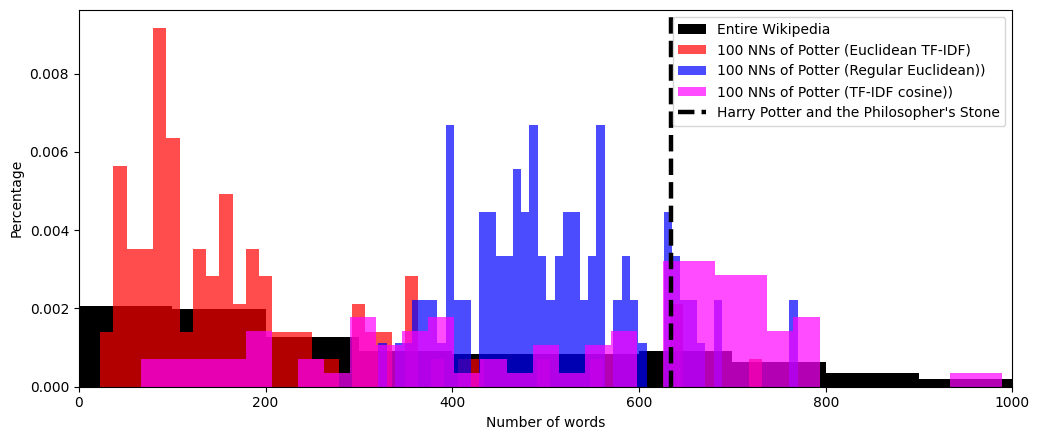

In [73]:
plt.figure(figsize=(10.5,4.5))
plt.hist(df.length, range=[0, 1000], density=True, color='black', label='Entire Wikipedia')
plt.hist(nn_tfidf_euclidean.length, bins=50, alpha=0.7, density=True, color='red', label='100 NNs of Potter (Euclidean TF-IDF)')
plt.hist(nn_regular_euclidean.length, bins=50, alpha=0.7, density=True, color='blue', label='100 NNs of Potter (Regular Euclidean))')
plt.hist(nn_tfidf_cosine.length, bins=50, alpha=0.7, density=True, color='magenta', label='100 NNs of Potter (TF-IDF cosine))')
plt.axvline(df.iloc[harry_potter_idx].length, label="Harry Potter and the Philosopher's Stone", color='black', linestyle='--', linewidth=3.2)


plt.xlabel("Number of words")
plt.ylabel("Percentage")
plt.xlim([0, 1000])
plt.legend()
plt.tight_layout()

The chart provides valuable insights into the performance of various approaches employed in this notebook.
- The preference for shorter descriptions is evident in the Euclidean TF-IDF combination. Generally, shorter Wikipedia pages often signify less popular topics. Consequently, movies selected through this method tended to be older and less popular, aligning seamlessly with this hypothesis.
- Results from the Euclidean norm without TF-IDF usage were closer to the desired answers; this method favored mid-length descriptions.
- The last attempt yielded the best results, as evident on the chart. This approach focused on articles of all lengths, especially those between 600 and 800, where all Harry Potter movies were located on the plot.